# Experiments with the diversity condition violated

In this notebook I will perform the SimCLR experiments where the diversity condition was violated. Mathematically it essentially means that we will use the following distributions for sampling:

- $p(z) = \frac{1}{|\mathcal{Z}|}$ - Marginal distribution is simply a uniform distribution on a sphere
- $p(\tilde{z}|z) = \delta(u-u') \frac{e^{\kappa \tilde{z}^{T}z}}{\int_{W}e^{\kappa v^{T}v' dv}}$

Where the latent space can be decomposed into 2 components $z = (u,v)^{T}$ where $u \in R^{n}$, $v \in R^{m}$, and $m + n = d$ - the dimension of the latent space.

I will primarily work with hyper-spheres as my latent space, hence the condition $z^{2} = u^{2} + v^{2} = 1$ will be enforced.

Experiment with these data-generating processes:

- Identity
- Linear Mapping (to 4D, 5D, 6D, 7D)
- Spirals
- Patches
- Injective Neural Network as a data generating process

For now fix one dimension (the first one):

Consider later:

- Fix multiple dimensions
- Fix dimensions randomly

In [1]:
%load_ext autoreload
%autoreload 2
    
import torch
from torch import nn
from torch import functional
from simclr.simclr import SimCLR
from encoders import get_mlp
import matplotlib.pyplot as plt
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

from encoders import get_mlp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

batch_size = 4096
kappa = 8
iterations = 3000
tau = kappa

fixed_dims_on_sample = 1

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:,:u_dim]
    v = z[:,u_dim:]

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch) * torch.norm(v, p=2, dim=-1, keepdim=True)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch) # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)
    
sample_uniform_fixed = lambda batch: full_sphere.uniform(batch)
sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, fixed_dims_on_sample)

/home/justinas/miniconda3/envs/cl_theory/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Using device: cuda


## Visualizing the constrained sampling procedure

Below you can see how samples from the constrained sampling distribution look like

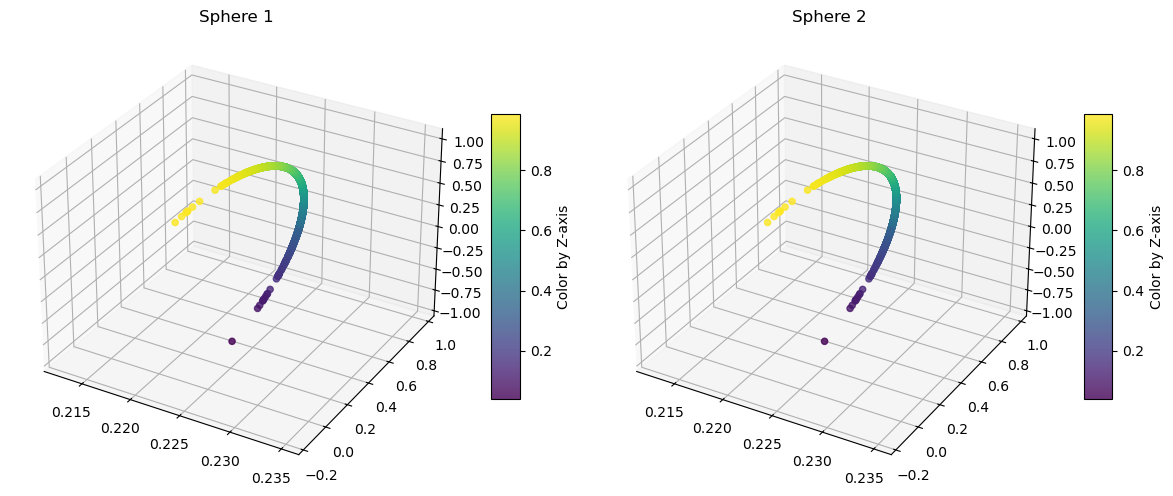

In [8]:
z = sample_uniform_fixed(1).squeeze(0)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch_size) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(batch_size, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

## Training the identity generating process

$g(z) = z$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.317989349365234 Samples processed: 1 linear disentanglement: 0.607282817363739 permutation disentanglement: 0.0010349949588999152
Loss: 8.199752807617188 Samples processed: 251 linear disentanglement: 0.8480098843574524 permutation disentanglement: 0.5719239711761475
Loss: 8.19973373413086 Samples processed: 501 linear disentanglement: 0.8986272811889648 permutation disentanglement: 0.6074317097663879
Loss: 8.199624061584473 Samples processed: 751 linear disentanglement: 0.9002280235290527 permutation disentanglement: 0.6114314198493958
Loss: 8.199615478515625 Samples processed: 1001 linear disentanglement: 0.8944796919822693 permutation disentanglement: 0.6020757555961609
Loss: 8.199621200561523 Samples processed: 1251 linear disentanglement: 0.8846526741981506 permutation disentanglement: 0.6033063530921936
Loss: 8.199575424194336 Samples processed: 1501 linear disentanglement: 0.8548588752746582 permutation disentangle

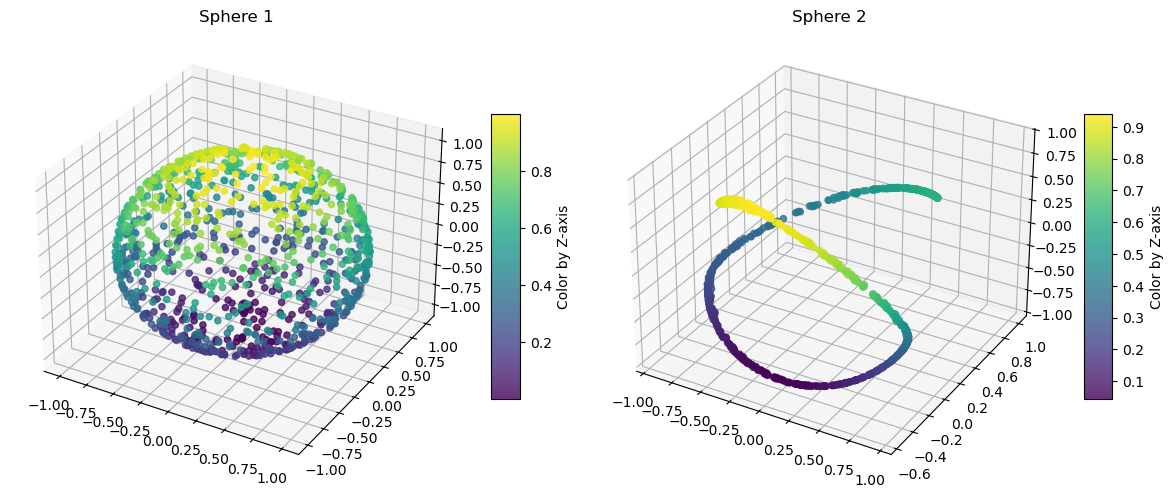

In [9]:
# Initialize the multi-layer perceptron used for encoding
f_constrained = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

g_id = nn.Identity()

h_constrained = lambda z: f_constrained(g_id(z))

simclr_vmf = SimCLR(
    f_constrained, g_id, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_constrained = simclr_vmf.train(batch_size, iterations)

z = full_sphere.uniform(1000).to(device)
z_enc = h_constrained(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Linear map generating process

$g(z) = Az$, where $A \in \mathbb{R}^{k \times 3}$ and $k \in \{4,5,6,7\}$ and $rank(A) = 3$

In [ ]:
from data.generation import InjectiveLinearDecoder

